| Aspect                | `sweep_degree`                                                                     | `sweep_ridge`                                                      |   |   |   |         |
| --------------------- | ---------------------------------------------------------------------------------- | ------------------------------------------------------------------ | - | - | - | ------- |
| What varies           | **Number of features p** (first p columns), `p = 1..deg_max`                       | **Regularization λ** for a **fixed** feature count (`degree`)      |   |   |   |         |
| Estimator             | **OLS** (no penalty)                                                               | **Ridge** (L2 penalty)                                             |   |   |   |         |
| Goal                  | Find how test error changes as model **capacity/complexity** (more features) grows | Find how test error changes with **shrinkage** at a fixed capacity |   |   |   |         |
| Outputs               | `degrees, mses, r2s, norms`                                                        | `mses, r2s, norms` (aligned to `lambdas`)                          |   |   |   |         |
| Bias–variance control | By **adding/removing features**                                                    | By **penalizing coefficients** (smaller                            |   | θ |   | as λ ↑) |
| Overfitting handling  | None (except early stopping at smaller p)                                          | Yes—λ>0 shrinks θ to reduce variance                               |   |   |   |         |


In [ ]:
# notebooks/01_OLS_degree.ipynb
import numpy as np
from src.data import make_data, build_features, train_test_scale
from src.models import sweep_degree, sweep_ridge
from src.plots import plot_mse_r2_vs_degree, plot_theta_norms, plot_ridge_curves

# data
x, y = make_data(n=100, noise_sd=0.1, seed=42)
deg_max = 15
X_full = build_features(x, degree=deg_max, include_bias=False)

# OLS vs degree
degrees, mse_deg, r2_deg, norms_deg = sweep_degree(X_full, y, deg_max=deg_max, split_func=train_test_scale)
plot_mse_r2_vs_degree(degrees, mse_deg, r2_deg, title="Runge: OLS vs degree")
plot_theta_norms(degrees, norms_deg, xlabel="Polynomial degree",
                 title=r"OLS coefficient size vs degree ($\|\theta\|_2$)")

# Ridge vs lambda (fixed degree)
p_fixed = 12
lambdas = np.logspace(-6, 2, 40)
mse_r, r2_r, norms_r = sweep_ridge(X_full, y, split_func=train_test_scale,
                                   degree=p_fixed, lambdas=lambdas, n_factor=True)
plot_ridge_curves(lambdas, mse_r, r2_r, title=f"Runge: Ridge vs λ (degree={p_fixed})")
plot_theta_norms(lambdas, norms_r, xlabel="λ (log scale)",
                 title=r"Ridge coefficient size vs λ ($\|\theta\|_2$)")


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import pinv
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.linear_model import LinearRegression, Ridge, Lasso 

Variables, inputs and outputs used in the code explained: 
- n: Number of datapoints, scalar
- deg: Maximum polynomial degree used to build features, scalar
- x: The input feature values
- y: The observed targets for each x. Runge function + noise
- y_data: The reference you compare against in R2 & MSE. 
- y_model: The predictions from your model. 
- y_mean: *Needs to be checked*
- X: Design matrix
- theta: The vector of model coefficients, computed by OLS. 
- X_train, X_test, y_train, y_test: Split of data between training and testing. 
- X_mean: The column-wise mean of X_train. 
- X_std: The column-wise standard deviation of X_train. 
- X_train_scaled, X_test_scaled: Standardized versions of X_train/X_test. 
- y_train_centered, y_test_centered: Targets with the training mean removed. 
- XT_X: $X^TX$
- XT_y: $X^Ty$

In [15]:
import numpy as np
from numpy.linalg import pinv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)
n   = 100
deg = 15

# Runge function first (so it's defined before use)
def runge(x):
    return 1 / (1 + 25 * x**2)

x = np.linspace(-1, 1, n).reshape(-1, 1)
y = runge(x) + np.random.normal(0, 0.1, size=x.shape)   # shape (n,1)

# Metrics
def MSE(y_data, y_model):
    return np.mean((y_data - y_model)**2)

def R2(y_data, y_model):
    y_mean = np.mean(y_data)
    return 1 - np.sum((y_data - y_model)**2) / np.sum((y_data - y_mean)**2)

# Build features up to max degree and split once
X_full = PolynomialFeatures(degree=deg, include_bias=False).fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, shuffle=True
)

# Standardize using TRAIN stats (no leakage)
X_mean = X_train.mean(axis=0)
X_std  = X_train.std(axis=0)
X_std[X_std == 0] = 1

X_train_s = (X_train - X_mean) / X_std
X_test_s  = (X_test  - X_mean) / X_std

# Center y so we can drop the intercept in the linear solve; add back later
y_mean = y_train.mean()
y_train_c = y_train - y_mean  # (n_train,1)

# Sweep degrees and collect test metrics
degrees     = list(range(1, deg + 1))
mse_scores  = []
r2_scores   = []
theta_norms = []

for p in degrees:
    Xtr_p = X_train_s[:, :p]
    Xte_p = X_test_s[:,  :p]

    # Solve least squares on centered targets
    theta_p, *_ = np.linalg.lstsq(Xtr_p, y_train_c, rcond=None)  # (p,1)

    # Predict (add back intercept y_mean)
    yhat_test_p = Xte_p @ theta_p + y_mean  # shape (n_test,1)

    # Metrics on uncentered test targets
    mse_scores.append(MSE(y_test, yhat_test_p))
    r2_scores.append(R2(y_test, yhat_test_p))
    theta_norms.append(np.linalg.norm(theta_p))

# (Optional) If you ALSO want the single full-degree model’s train/test metrics:
Xtr_full = X_train_s[:, :deg]
Xte_full = X_test_s[:,  :deg]
theta_full, *_ = np.linalg.lstsq(Xtr_full, y_train_c, rcond=None)
yhat_train_full = Xtr_full @ theta_full + y_mean
yhat_test_full  = Xte_full @ theta_full + y_mean

print("Full-degree (deg=15) Train MSE:", MSE(y_train, yhat_train_full))
print("Full-degree (deg=15) Test  MSE:", MSE(y_test,  yhat_test_full))
print("Full-degree (deg=15) Train R2 :", R2(y_train, yhat_train_full))
print("Full-degree (deg=15) Test  R2 :", R2(y_test,  yhat_test_full))


Full-degree (deg=15) Train MSE: 0.007407226451046568
Full-degree (deg=15) Test  MSE: 0.012289209887177159
Full-degree (deg=15) Train R2 : 0.9200417888177215
Full-degree (deg=15) Test  R2 : 0.8218682948718259


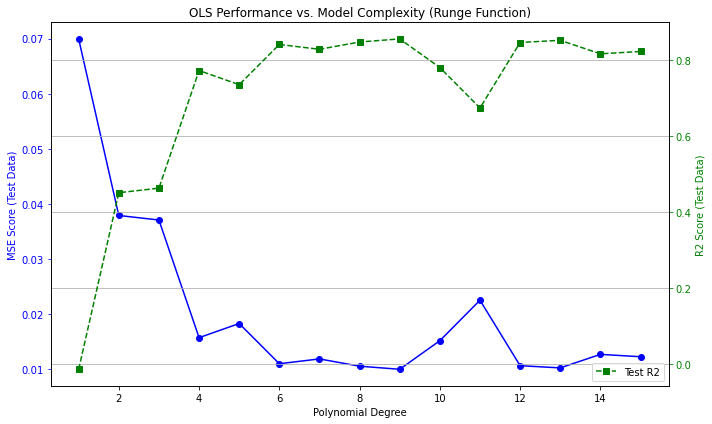

In [16]:
# Plot 1: MSE and R2 scores as functions of polynomial degree [4]
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(degrees, mse_scores, 'b-o', label='Test MSE')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('MSE Score (Test Data)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('OLS Performance vs. Model Complexity (Runge Function)')

# Create a second axis for R2 score
ax2 = ax1.twinx() 
ax2.plot(degrees, r2_scores, 'g--s', label='Test R2')
ax2.set_ylabel('R2 Score (Test Data)', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

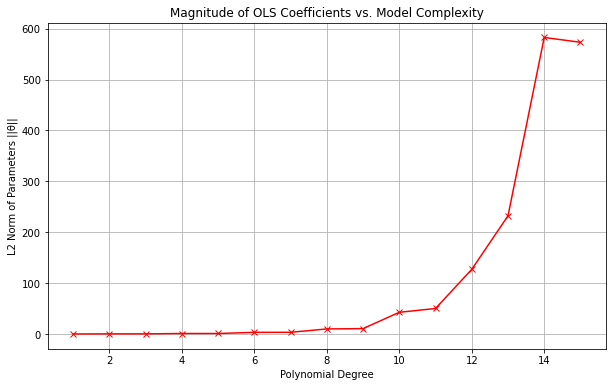

In [14]:
# Plot 2: Parameters θ as you increase the order of the polynomial [4]
plt.figure(figsize=(10, 6))
plt.plot(degrees, theta_norms, 'r-x')
plt.xlabel('Polynomial Degree')
plt.ylabel('L2 Norm of Parameters ||θ||')
plt.title('Magnitude of OLS Coefficients vs. Model Complexity')
plt.grid(True)
plt.show()

Yes—this plot makes sense.

What it shows

* The **L2 norm of the OLS coefficients** grows slowly for small–moderate polynomial degrees, then **shoots up for high degrees**.
* That spike is typical with polynomial regression on noisy data (Runge-like function): the **Vandermonde design becomes ill-conditioned** and the model uses very large, cancelling coefficients to chase noise ⇒ big $\|\theta\|_2$.

Why it happens

* **High powers** of $x$ are nearly collinear with lower powers → $X^\top X$ is ill-conditioned.
* With noise, OLS picks a very **wiggly** function; large coefficients are the “lever” that creates those wiggles.
* Even with feature scaling, this blow-up still occurs (scaling helps but doesn’t fix ill-conditioning).

Notes on the shape

* A **sharp rise** near the highest degrees is expected.
* It **needn’t be perfectly monotonic** (your slight dip at 15 vs 14 is fine) because of train/test split and noise.

If you want to tame it / double-check:

* Plot **log-scale** on y: `plt.yscale('log')`.
* Try **ridge**: norms will shrink smoothly as $\lambda$ increases.
* Use **orthogonal polynomials** (Legendre/Chebyshev) or **basis scaling** to improve conditioning.
* Optionally report the **condition number** of $X^\top X$ vs degree to quantify the instability.

So: the rising $\|\theta\|_2$ with degree is exactly the overfitting/ill-conditioning story you’d expect here.


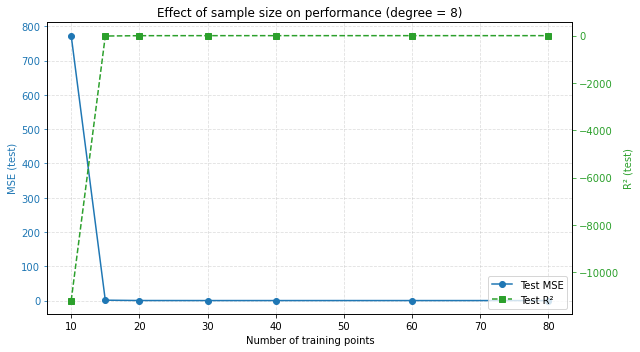

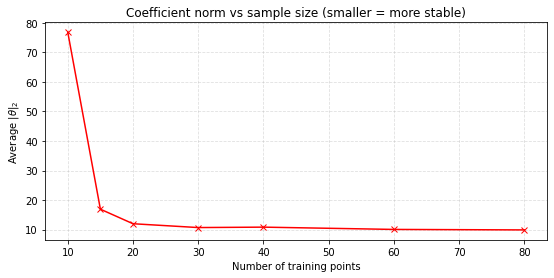

In [17]:
# --- Dependence on the number of data points (fixed polynomial degree) ---

p_fixed = 8                                  # choose an "interesting" degree
Xtr_fixed = X_train_s[:, :p_fixed]
Xte_fixed = X_test_s[:,  :p_fixed]

train_sizes = [10, 15, 20, 30, 40, 60, 80]   # must be <= X_train_s.shape[0]
reps = 100                                   # avg over repetitions to reduce noise

mse_vs_n, r2_vs_n, theta_norm_vs_n = [], [], []

for m in train_sizes:
    mse_acc, r2_acc, norm_acc = 0.0, 0.0, 0.0
    for _ in range(reps):
        # sample m rows from the training pool (without replacement)
        idx = np.random.choice(Xtr_fixed.shape[0], size=m, replace=False)
        Xtr_m = Xtr_fixed[idx]
        ytr_m = y_train_c[idx]                # centered targets (remember we add y_mean back)

        # least-squares fit on the m points
        theta_m, *_ = np.linalg.lstsq(Xtr_m, ytr_m, rcond=None)

        # predict on the fixed test set; restore intercept by adding y_mean
        yhat_test_m = Xte_fixed @ theta_m + y_mean

        # accumulate metrics on the original (uncentered) y_test
        mse_acc  += MSE(y_test, yhat_test_m)
        r2_acc   += R2(y_test, yhat_test_m)
        norm_acc += np.linalg.norm(theta_m)

    mse_vs_n.append(mse_acc / reps)
    r2_vs_n.append(r2_acc / reps)
    theta_norm_vs_n.append(norm_acc / reps)

# --- Plots ---
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 5))
l1, = ax1.plot(train_sizes, mse_vs_n, 'o-', color='C0', label='Test MSE')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('MSE (test)', color='C0')
ax1.tick_params(axis='y', colors='C0')
ax1.grid(True, ls='--', alpha=0.4)

ax2 = ax1.twinx()
l2, = ax2.plot(train_sizes, r2_vs_n, 's--', color='C2', label='Test R²')
ax2.set_ylabel('R² (test)', color='C2')
ax2.tick_params(axis='y', colors='C2')

# single legend
lines = [l1, l2]
ax1.legend(lines, [ln.get_label() for ln in lines], loc='lower right')
plt.title(f'Effect of sample size on performance (degree = {p_fixed})')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(train_sizes, theta_norm_vs_n, 'r-x')
plt.xlabel('Number of training points')
plt.ylabel(r'Average $\|\theta\|_2$')
plt.title('Coefficient norm vs sample size (smaller = more stable)')
plt.grid(True, ls='--', alpha=0.4)
plt.show()


b

In [20]:
nlambdas = 100
lambdas = np.logspace(-10, 5, nlambdas)

mse_ridge_scores = []
r2_ridge_scores = []
theta_ridge_norms = []

XT_X = X_train_scaled.T @ X_train_scaled
XT_y = X_train_scaled.T @ y_train_centered
I = np.eye(deg)

for lam in lambdas:
    # closed-form ridge
    theta_r = np.linalg.solve(XT_X + n_tr * lam * I, XT_y)
    yhat_te = Xte @ theta_r + y_mu

    mse_ridge.append(MSE(y_te, yhat_te))
    r2_ridge.append(R2(y_te,  yhat_te))
    theta_norms.append(np.linalg.norm(theta_r))
    
mse_ridge = np.array(mse_ridge)
r2_ridge  = np.array(r2_ridge)
theta_norms = np.array(theta_norms)
